# Common import statements
For different splits go to the respective sections.

In [74]:
import pandas as pd
from pandas import DataFrame as df
import IPython as ip
import re
import numpy as np
import time

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
# Set input dir
import sys
sys.path.append("/home/mschlupp/pythonTools")
files_dir = "files/"
%matplotlib inline

## Split data into `hasEvents` and `noEvents`

In [105]:
ga_full = pd.read_csv(files_dir+"traintest_fullevt.csv")

In [10]:
ga_hasEvts = ga_full[ga_full.hasEvents>0]

In [9]:
ga_noEvts = ga_full[ga_full.hasEvents==0]

In [13]:
ga_noEvts = ga_noEvts.drop(["hasEvents", "nEvts", "longitude_mean"
                , "longitude_variance", "latitude_mean"
                , "latitude_variance", "usageTime_mean"
                , "usageTime_variance", "usageDay_mean"
                ,"usageDay_variance"], axis=1)

In [14]:
ga_noEvts.to_csv("files/ga_noEvts.csv", index=False)

In [15]:
ga_hasEvts.to_csv("files/ga_hasEvts.csv", index=False)

In [17]:
%ls files/

app_events.csv              label_categories.csv
app_labels.csv              phone_brand_device_model.csv
apps_labels_categories.csv  phone_brand_device_model_engl.csv
events.csv                  sample_submission.csv
events_day_hour.csv         traintest_fullevt.csv
ga_hasEvts.csv              traintest_phone.csv
ga_noEvts.csv               traintest_phone_day_hour.csv
gender_age_test.csv         traintest_phone_evts.csv
gender_age_train.csv


## Split events data in ```hasApp``` and ```noApp```

In [7]:
evts= pd.read_csv("files/events_day_hour.csv", index_col=0)

In [6]:
ga_evts = pd.read_csv("files/ga_hasEvts.csv")

In [111]:
ga_evts.tail(2)

,age,device_id,gender,group,isTrain,phone_brand,device_model,hasEvents,nEvts,longitude_mean,longitude_variance,latitude_mean,latitude_variance,usageTime_mean,usageTime_variance,usageDay_mean,usageDay_variance
58501,-1,2160204780761637517,none,none,0,vivo,Y17T,1,5,106.01,0,32.05,0,0.000,0.000000,0.0,0.000000
58502,-1,7583643168012624381,none,none,0,华为,荣耀6 Plus,1,8,0.00,0,0.00,0,12.375,6.839286,3.5,0.285714


There are actually devide_ids that are not in the training and test set, but present in the events data. First get rid of those.

Eg:

In [9]:
-8295895346874348777 in ga_evts.device_id.values

False

In [151]:
# this is not very fast!
#ll = evts.device_id.map(lambda x: x in ga_evts.device_id.values)
#ll.value_counts()

#True     3160417
#False      92533
#Name: device_id, dtype: int64

In [153]:
# ask if the evts.device_id is in ga_evts
evts=evts.drop(["timestamp"],axis=1)
evts=evts[list(map(lambda x: x in ga_evts.device_id.values,evts.device_id))]

In [155]:
len(evts)

3160417

In [157]:
evts.to_csv("files/evts_ga_aligned_ids.csv", index=False)

Ok now all `device_id` entries are present in the train and test samples.

In [112]:
#read file in chunks, because else we run in memory troubles
size=50000
evts_chunks= pd.read_csv("files/evts_ga_aligned_ids.csv", chunksize=size)

In [113]:
evts = pd.DataFrame()

In [114]:
# this got a bit more complicated than necessary due to missing device ids

# add training flag and write output to file
#start=time.time()
#for i,chunk in enumerate(evts_chunks): 
#    l=list()
#    for x in chunk.device_id.values:
#        l.append(ga_evts[ga_evts.device_id==x].isTrain.values[0])    
#    chunk["isTrain"]=l
    #print(type(l), "\n", l)
#    if i % 10 == 0:
#        t = time.time()
#        print(i*size/1e3, "k events processed! Took: ", (t-start)/60., " minutes.")
#    if i==0:
#        evts = chunk #.to_csv("files/finalSets/evts_withTrain.csv", mode='w')
#    else:
#        evts = evts.append(chunk, ignore_index=True) #.to_csv("files/finalSets/evts_withTrain.csv", mode='a',header=False)
        
# print("\n\n done in ", (time.time()-s)/60., " minutes")
# horribly slow: about 50 minutes

# try to be faster
# that's so much faster!! --> 0.8 minutes!
start=time.time()
for i,chunk in enumerate(evts_chunks): 
    chunk = chunk.merge(ga_evts[["device_id","isTrain", "group"]]
                        ,on="device_id", how="left")
    #print(type(l), "\n", l)
    if i % 10 == 0:
        t = time.time()
        print((i+1)*size/1e3, "k events processed! Took: ", (t-start)/60., " minutes.")
    if i==0:
        evts = chunk 
    else:
        evts = pd.concat([evts,chunk], ignore_index=True)
        
print("\n\n done in ", (time.time()-start)/60., " minutes")

50.0 k events processed! Took:  0.002494255701700846  minutes.
550.0 k events processed! Took:  0.03510509729385376  minutes.
1050.0 k events processed! Took:  0.09955893754959107  minutes.
1550.0 k events processed! Took:  0.17054517269134523  minutes.
2050.0 k events processed! Took:  0.2602207104365031  minutes.
2550.0 k events processed! Took:  0.37145033677419026  minutes.
3050.0 k events processed! Took:  0.502344552675883  minutes.


 done in  0.5552177627881368  minutes


In [115]:
# take device with highest amount of events occurrances
evts.device_id.value_counts().head(1)

1186608308763918427    33426
Name: device_id, dtype: int64

In [116]:
# test if the merge was successful
print(ga_evts.isTrain[ga_evts.device_id==1186608308763918427])
evts[evts.device_id==1186608308763918427].isTrain.value_counts()

55072    0
Name: isTrain, dtype: int64


0    33426
Name: isTrain, dtype: int64

Ok this worked.
Event for the device with the highest number of event occurrences, the `isTrain` flag is correctly set for all of them! Great improvement in speed!!

In [82]:
evts.to_csv(files_dir+"finalSets/evts_withTrain.csv", index=False)

## We start to split data

In [2]:
evts = pd.read_csv("files/finalSets/evts_withTrain.csv")

In [83]:
len(evts)

3160417

In [119]:
# now we need the event ids from the apps data
app_evt_id = pd.read_csv("files/app_events.csv", usecols=["event_id"]
                         , dtype=np.float64)

In [120]:
app_evt_id =  pd.DataFrame(app_evt_id.event_id.unique(), columns=["event_id"])

In [100]:
len(app_evt_id)

1488096

In [122]:
evts_hasApp = evts.merge(app_evt_id, on="event_id", how="inner")

In [123]:
print(len(evts_hasApp))
evts_hasApp.head(5)

1446145


,event_id,device_id,longitude,latitude,day,time,hour,usageDay,isTrain,group
0,2,-6401643145415154744,103.65,30.97,Sun,00:54:12,0,3,0,none
1,6,1476664663289716375,0.00,0.00,Sun,00:27:21,0,3,1,M22-
2,7,5990807147117726237,113.73,23.00,Sun,00:15:13,0,3,0,none
3,9,-2073340001552902943,0.00,0.00,Sun,00:15:33,0,3,0,none
4,16,9070651185984875886,0.00,0.00,Sun,00:06:06,0,3,0,none


In [124]:
evts_hasApp.to_csv(files_dir+"finalSets/evts_hasApp.csv", index=False)

In [134]:
evts_noApp = evts.loc[~(evts["event_id"].isin(evts_hasApp.event_id))]

In [136]:
len(evts_noApp)+len(evts_hasApp) == len(evts)

True

Cool this worked. Now write the last split to csv and call it a day.

In [137]:
evts_noApp.to_csv(files_dir+"finalSets/evts_noApp.csv", index=False)

# Now continue with the AppData
Here we need to merge the data with the events data that have App information

In [12]:
evts_hasApp = pd.read_csv(files_dir+"finalSets/evts_hasApp.csv")

In [7]:
print(evts_hasApp.shape)
evts_hasApp.head(2)

(1446145, 10)


,event_id,device_id,longitude,latitude,day,time,hour,usageDay,isTrain,group
0,2,-6401643145415154744,103.65,30.97,Sun,00:54:12,0,3,0,none
1,6,1476664663289716375,0.00,0.00,Sun,00:27:21,0,3,1,M22-


This dataset will be merged with the app information. So let's get the app data.

In [5]:
%ls files | grep "app"

app_events.csv
app_labels.csv
apps_labels_categories.csv


In [17]:
app_info = pd.read_csv(files_dir+"app_events.csv")

In [8]:
print(app_info.shape)
app_info.head(2)

(32473067, 4)


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0


In [16]:
evts_hasApp.event_id[evts_hasApp.device_id==-6401643145415154744].head()

0              2
28769      65269
94142     212044
153947    346841
155249    349776
Name: event_id, dtype: int64

In [18]:
app_info = app_info[app_info.event_id.isin([2,65269,212044,346841,349776])]

In [19]:
group_evt = app_info.groupby("event_id")

In [20]:
for x in group_evt.groups:
    print(group_evt.get_group(x))

         event_id               app_id  is_installed  is_active
3524035    349776  5927333115845830913             1          0
3524036    349776 -5720078949152207372             1          0
3524037    349776 -1633887856876571208             1          0
3524038    349776  8693964245073640147             1          0
3524039    349776 -8438435939794089197             1          1
3524040    349776  4775896950989639373             1          0
3524041    349776  9112463267739110219             1          0
3524042    349776 -3725672010020973973             1          0
3524043    349776  7167114343576723123             1          1
3524044    349776  7460082553072507347             1          0
3524045    349776   628020936226491308             1          0
3524046    349776   701031210314548601             1          0
3524047    349776 -1758857579862594461             1          0
3524048    349776  4348659952760821294             1          0
3524049    349776 -8942695423876075857  

It seems as if there are different active apps per event and device. Sometimes there is also information about the if an app is installed or not.
From now on we only consider app information about the apps that are installed and active in an event. Indeed, there are no app that are active but not installed.

In [33]:
# load full data again and then drop all that is not active in one event
app_info = pd.read_csv(files_dir+"app_events.csv")

In [37]:
# lets check if there are events with no active app
app_info.groupby("event_id")["is_active"].agg(np.sum).value_counts().sort_index().head(2)

0     11037
1    126837
Name: is_active, dtype: int64

In [67]:
df = pd.DataFrame(app_info.groupby("event_id")["is_active"].agg(np.sum))
df.columns = ["nActiveApps"]
df["event_id"] = df.index
df.index= range(len(df))

In [69]:
# ok there are events with no active app
# let's create a feature that counts the number of active apps per event
evts_hasApp = evts_hasApp.merge(df, on="event_id", how="left")

In [84]:
gp = evts_hasApp.groupby("group")

In [90]:
?sns.distplot

/home/mschlupp/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


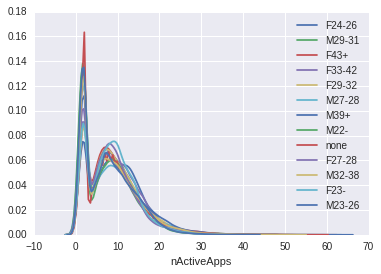

In [91]:
for x in gp.groups:
    sns.distplot(gp.get_group(x).nActiveApps, hist=False, label=x);

Here we have minor differences, which might help us with other variables.

In [92]:
app_info = app_info.loc[(app_info.is_active ==1 )]

In [93]:
app_info = app_info.drop(["is_installed"], axis=1)
app_info.head(2)

,event_id,app_id,is_active
0,2,5927333115845830913,1
3,2,-653184325010919369,1


We'd like to categorise the `app_id`s so we need label information.